In [1]:
!pip install torch torchvision torchaudio torch-geometric rdkit matplotlib deepdish tqdm

In [2]:
import sys
import torch
import torch_geometric
import deepdish as dd
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RANSACRegressor
from scipy.stats import pearsonr, spearmanr, linregress
from os.path import join
from rdkit.Chem.rdmolfiles import MolFromMolFile
from rdkit import Chem
from rdkit.Chem import AllChem

from torch.nn import Sequential, Linear, ReLU, BatchNorm1d, Dropout, GRU
from torch_geometric.nn import GCNConv, GATConv, GINConv, global_mean_pool
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader


sns.set()
%matplotlib notebook

In [3]:
def add_edges_list(root, code):
    ligand_filename = code + "_h.sdf"
    m = MolFromMolFile(join(root, code, ligand_filename))
    atoms1 = [b.GetBeginAtomIdx() for b in m.GetBonds()]
    atoms2 = [b.GetEndAtomIdx() for b in m.GetBonds()]    
    edge_weights = []
    coords = m.GetConformers()[0].GetPositions()  
    for b in m.GetBonds():
        bond_type = str(b.GetBondType())
        edge_weights.append({"SINGLE": 1, "DOUBLE": 2, "TRIPLE": 3}.get(bond_type, 4))
    edge_features = np.array(edge_weights)
    return np.array([atoms1 + atoms2, atoms2 + atoms1]), np.concatenate((edge_features, edge_features), 0)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)  # Ensure NumPy arrays
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def adjusted_r2_score(y_true, y_pred, num_features):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    n = len(y_true)  # Number of samples
    r2 = r2_score(y_true, y_pred)
    return 1 - ((1 - r2) * (n - 1)) / (n - num_features - 1)


In [4]:
class PDBbindDataset(InMemoryDataset):
    def __init__(self, root, node_features, activity_csv, transform=None, pre_transform=None):
        self.root = root
        self.node_features = node_features
        self.activity_csv = activity_csv
        super(PDBbindDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ["data.pt"]

    def download(self):
        pass

    def process(self):
        self.node_data = dd.io.load(join(self.root, self.node_features))
        self.activity = pd.read_csv(join(self.root, self.activity_csv))
        self.edge_indexes = {key: add_edges_list(self.root, key)[0] for key in self.activity.PDB}
        self.edge_data = {key: add_edges_list(self.root, key)[1] for key in self.activity.PDB}

        data_list = [
            Data(
                x=torch.FloatTensor(self.node_data[key]),
                edge_index=torch.LongTensor(self.edge_indexes[key]),
                edge_attr=torch.FloatTensor(self.edge_data[key]),
                y=torch.FloatTensor([self.activity[self.activity.PDB == key].pk.iloc[0]])
            )
            for key in self.activity.PDB
        ]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])


In [5]:
path_to_test_directory = "D:/Downloads/coreset2016" 
path_to_test_complexes_features =  "D:/Downloads/coreset2016/coreset.h5"
path_to_test_complexes_true_affinity = "D:/Downloads/coreset2016/coreset2016.csv"

coreset = PDBbindDataset(
    path_to_test_directory,
    path_to_test_complexes_features,
    path_to_test_complexes_true_affinity
)
test_loader = DataLoader(coreset, batch_size=1, shuffle=False)


C:\Users\Sivad\AppData\Local\Temp\ipykernel_26436\3351529097.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])

In [6]:
from Models.graphLambda import Net
import torch

def update_state_dict(state_dict):
    new_state_dict = {}
    for key, value in state_dict.items():
        if 'lin_src.weight' in key:
            new_key = key.replace('lin_src.weight', 'lin.weight')
        elif 'lin_dst.weight' in key:
            new_key = key.replace('lin_dst.weight', 'lin.weight')
        else:
            new_key = key
        new_state_dict[new_key] = value
    return new_state_dict

model1 = Net()
model2 = Net()
model3 = Net()
model4 = Net()

state_dict1 = torch.load('GNNs_fusion_rand_split.pt', weights_only=True)
state_dict2 = torch.load('GNNs_fusion_TM_split.pt', weights_only=True)
state_dict3 = torch.load('GNNs_fusion_lig2lig_split.pt', weights_only=True)
state_dict4 = torch.load('GNNs_fusion_interaction_split.pt', weights_only=True)

model1.load_state_dict(update_state_dict(state_dict1))
model2.load_state_dict(update_state_dict(state_dict2))
model3.load_state_dict(update_state_dict(state_dict3))
model4.load_state_dict(update_state_dict(state_dict4))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1, model2, model3, model4 = model1.to(device), model2.to(device), model3.to(device), model4.to(device)


In [7]:
@torch.no_grad()
def test_predictions(model, loader):
    model.eval()
    pred = []
    true = []
    for data in loader:
        data = data.to(device)
        pred += model(data).detach().cpu().numpy().tolist()
        true += data.y.detach().cpu().numpy().tolist()
    return pred, true

test_loader = DataLoader(coreset, batch_size=64, shuffle=False)
pred1, true1 = test_predictions(model1, test_loader)
pred2, true2 = test_predictions(model2, test_loader)
pred3, true3 = test_predictions(model3, test_loader)
pred4, true4 = test_predictions(model4, test_loader)


<IPython.core.display.Javascript object>


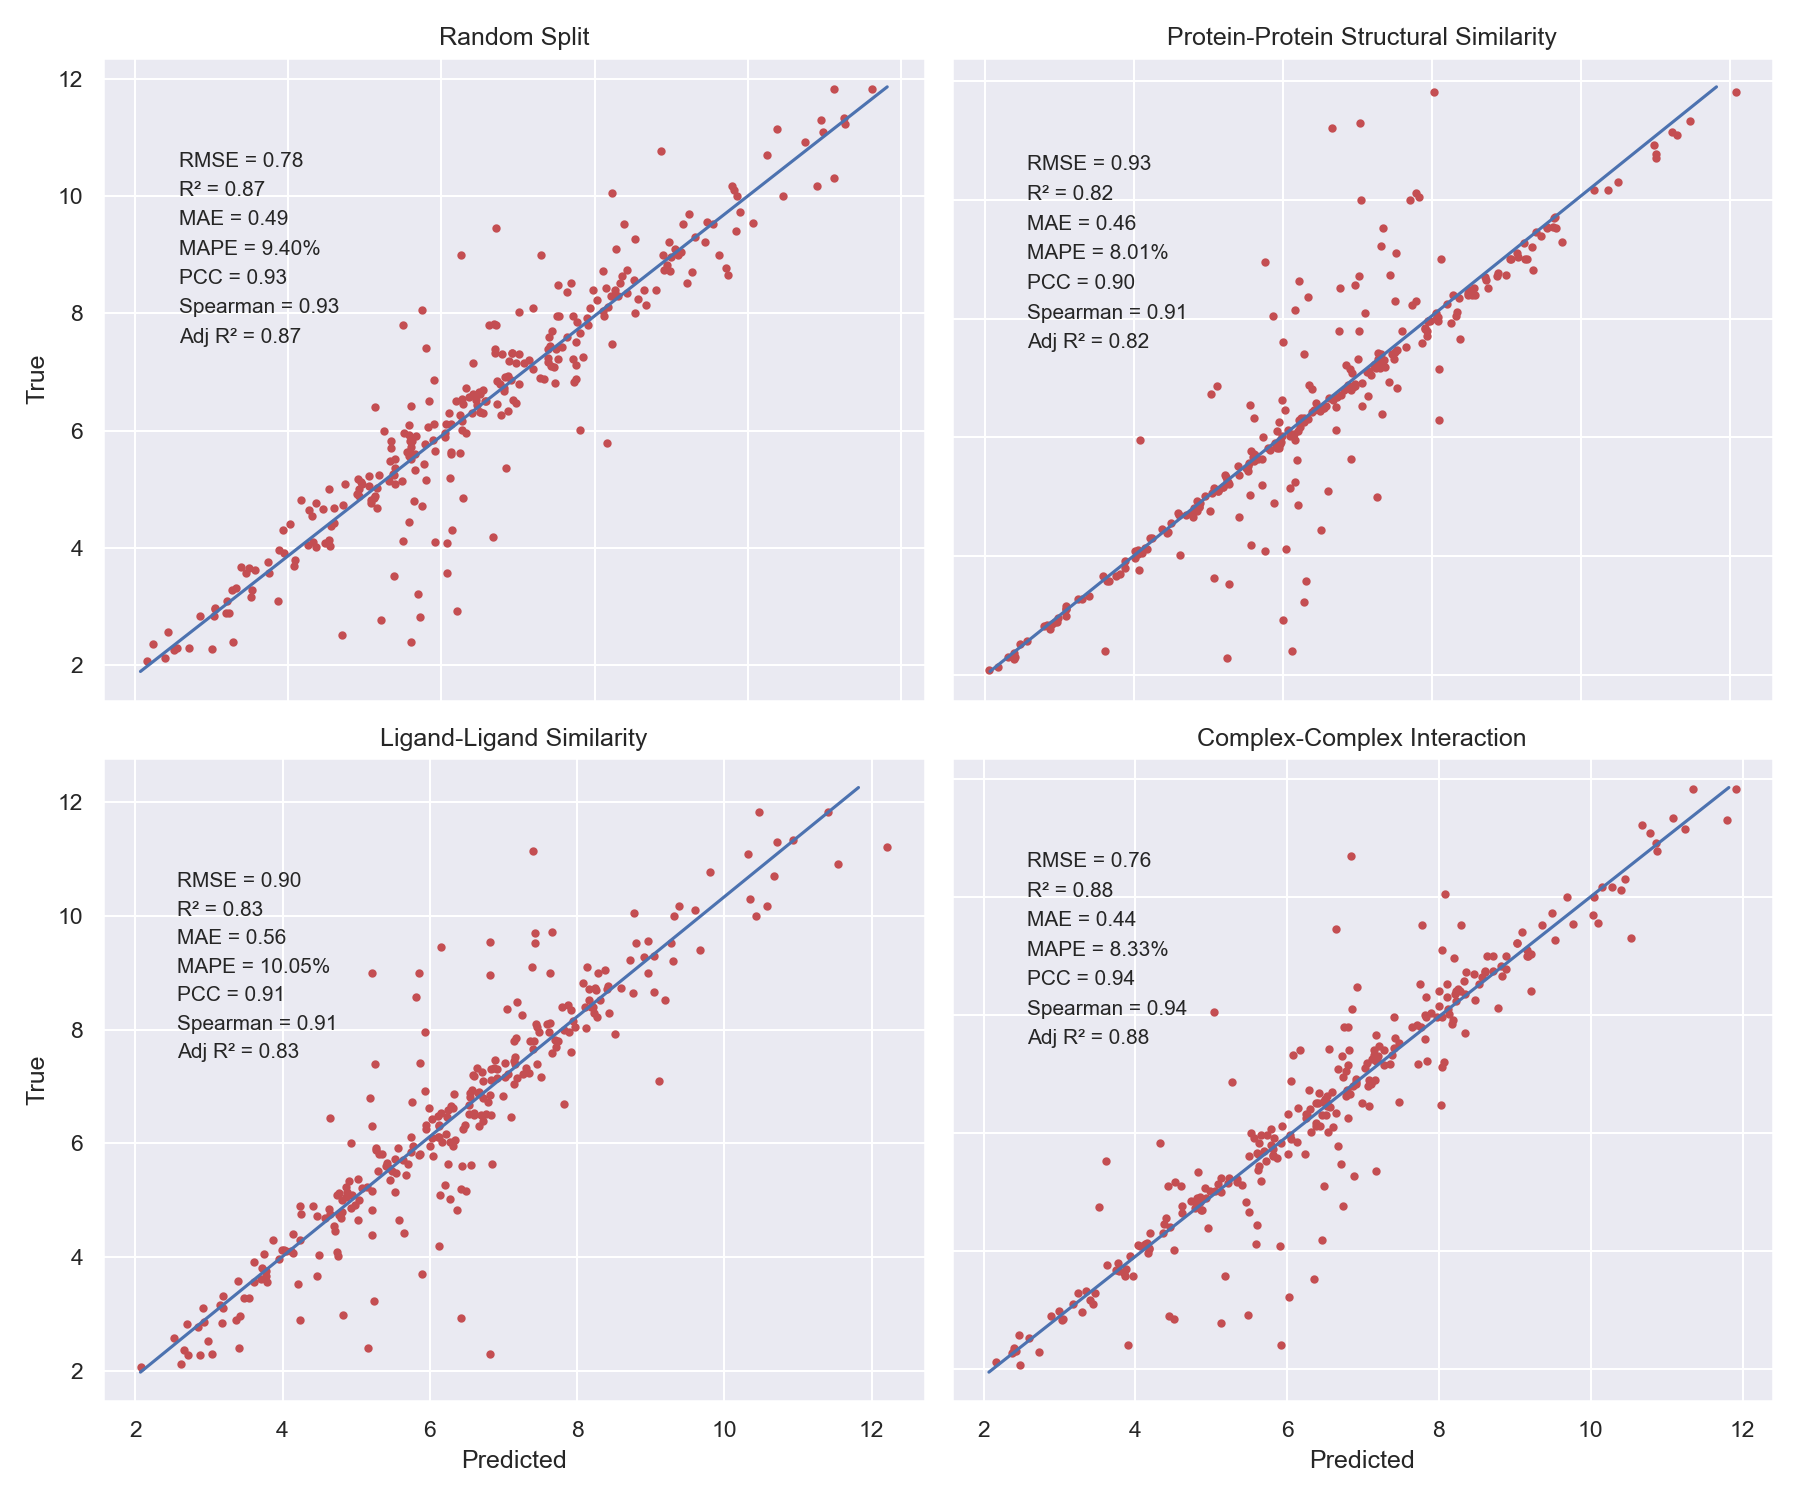

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, (pred, true, title) in enumerate(
    zip(
        [pred1, pred2, pred3, pred4],
        [true1, true2, true3, true4],
        ["Random Split", "Protein-Protein Structural Similarity", 
         "Ligand-Ligand Similarity", "Complex-Complex Interaction"]
    )
):
    row, col = divmod(i, 2)
    axs[row, col].plot(pred, true, "r.")
    axs[row, col].plot(np.unique(true), np.poly1d(np.polyfit(pred, true, 1))(np.unique(true)))

    # Adjusting annotation positions for better readability
    y_start = 10.5  # Starting position for text
    y_step = 0.5  # Gap between lines
    text_x = min(true) + 0.5  # Adjust X position to align to the left

    axs[row, col].text(
        text_x, y_start, f"RMSE = {math.sqrt(mean_squared_error(true, pred)):.2f}", fontsize=10
    )
    axs[row, col].text(
        text_x, y_start - y_step, f"R² = {r2_score(true, pred):.2f}", fontsize=10
    )
    axs[row, col].text(
        text_x, y_start - 2 * y_step, f"MAE = {mean_absolute_error(true, pred):.2f}", fontsize=10
    )
    axs[row, col].text(
        text_x, y_start - 3 * y_step, f"MAPE = {mean_absolute_percentage_error(true, pred):.2f}%", fontsize=10
    )
    axs[row, col].text(
        text_x, y_start - 4 * y_step, f"PCC = {pearsonr(true, pred)[0]:.2f}", fontsize=10
    )
    axs[row, col].text(
        text_x, y_start - 5 * y_step, f"Spearman = {spearmanr(true, pred)[0]:.2f}", fontsize=10
    )
    axs[row, col].text(
        text_x, y_start - 6 * y_step, f"Adj R² = {adjusted_r2_score(true, pred, 1):.2f}", fontsize=10
    )
    axs[row, col].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="Predicted", ylabel="True")
    ax.label_outer()

plt.tight_layout()
plt.show()
